In [1]:
import pandas as pd
import numpy as np
import re



In [2]:
data = pd.read_csv("../contents/IMDB_Dataset.csv")
data


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
# Data cleaning
data["clean_text"] = data["review"].apply(lambda x: re.sub("<.*?>", "", x))
data["clean_text"] = data["clean_text"].apply(lambda x: re.sub(r'[^\w\s]', "", x))
data["clean_text"] = data["clean_text"].str.lower()


In [6]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [7]:
# Tokenization
nltk.download('punkt')
data["tokenized_text"] = data["clean_text"].apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\malli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
# Remove stopwords
nltk.download('stopwords')
sw = set(stopwords.words("english"))
data["filtered_data"] = data["tokenized_text"].apply(lambda x: [word for word in x if word not in sw])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\malli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Stemming
stemmer = PorterStemmer()
data["lemma_text"] = data["filtered_data"].apply(lambda x: [stemmer.stem(word) for word in x])

In [10]:
# Prepare the data for model training
x = data["lemma_text"].apply(lambda x: " ".join(x))
y = data["sentiment"]

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [12]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [13]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(x_train)
x_test = tfidf.transform(x_test)


In [14]:
# Label Encoding
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [15]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

In [16]:
# Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [17]:
# Build the model
model = Sequential([
    Dense(128, activation="relu", input_shape=(x_train.shape[1],)),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(2, activation="sigmoid"),
])

C:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [19]:
# Train the model
model.fit(x_train, y_train, epochs=10)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 243s 192ms/step - accuracy: 0.8426 - loss: 0.3726
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 238s 190ms/step - accuracy: 0.9720 - loss: 0.0836
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 265s 192ms/step - accuracy: 0.9918 - loss: 0.0240
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 240s 192ms/step - accuracy: 0.9977 - loss: 0.0066
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 238s 190ms/step - accuracy: 0.9990 - loss: 0.0034
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 946s 169ms/step - accuracy: 0.9996 - loss: 0.0012
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 236s 189ms/step - accuracy: 0.9995 - loss: 0.0019
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - accuracy: 0.9990 - loss: 0.0036
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 115ms/step - accuracy: 0.9996 - loss: 0.0010
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 144s 115ms/step - accuracy: 0.9999 - loss: 2.7478e-04


In [45]:
import joblib

In [46]:
# Save the model and TF-IDF vectorizer
joblib.dump(model, "model.pkl")
joblib.dump(tfidf, "tfidf.pkl")

['tfidf.pkl']

In [20]:
from sklearn.metrics import f1_score
y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)  # Convert predictions to class labels
y_test_classes = y_test.argmax(axis=1)  # Convert one-hot encoded test labels to class labels


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [21]:
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print(f"F1 Score: {f1:.4f}")


F1 Score: 0.8725


In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [24]:
cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[4092  869]
 [ 403 4636]]


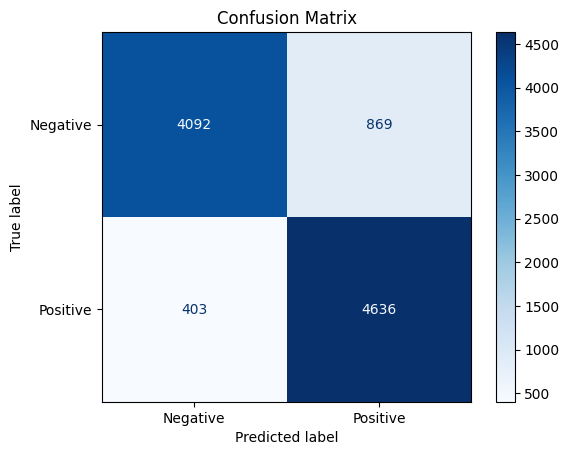

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
